In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import PIL
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
ACTIONS = [['LEFT'], ['RIGHT'], ['LEFT', 'DOWN'], ['RIGHT', 'DOWN'], ['DOWN'],
           ['DOWN', 'B'], ['B']]

In [3]:
from torchvision.models import alexnet
anet = alexnet(pretrained=True)
print(anet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
from visualize.visualize import gen_eval_vid_frame
from a2c_ppo_acktr.envs import make_vec_envs

from PIL import Image

In [5]:
model_path = "saved-runs/05-13_04-14-36/ppo/GreenHillZone.Act1/ckpts/runs_05-13_04-14-36_ppo_GreenHillZone.Act1-1001472.pt"
model = torch.load(model_path)
print(model)

[Policy(
  (base): CNNBase(
    (main): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten()
      (7): Linear(in_features=55296, out_features=512, bias=True)
      (8): ReLU()
    )
    (critic_linear): Linear(in_features=512, out_features=1, bias=True)
  )
  (dist): Categorical(
    (linear): Linear(in_features=512, out_features=7, bias=True)
  )
), 1001472, 848, 'runs_05-13_04-14-36_ppo_GreenHillZone.Act1']


In [6]:
seed = 10
device = "cuda:0"
env_state = "GreenHillZone.Act1"
env = make_vec_envs(
    [env_state],
    seed + 1000,
    1,
    None,
    device=device,
    allow_early_resets=False,
    mode='eval')

['B']
(274, 960, 3)


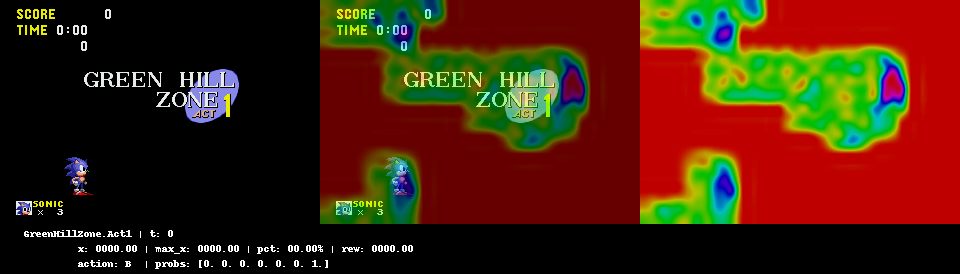

['RIGHT']
(274, 960, 3)


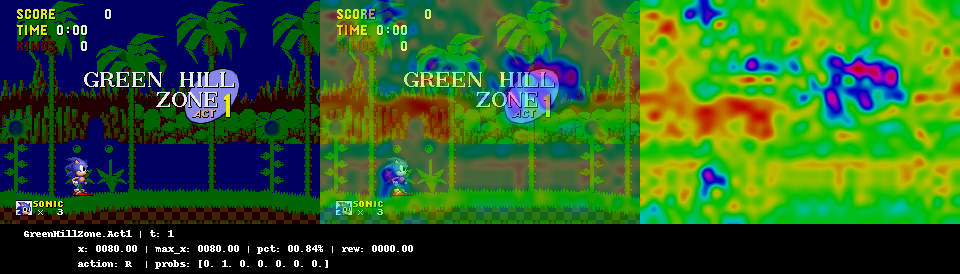

['RIGHT']
(274, 960, 3)


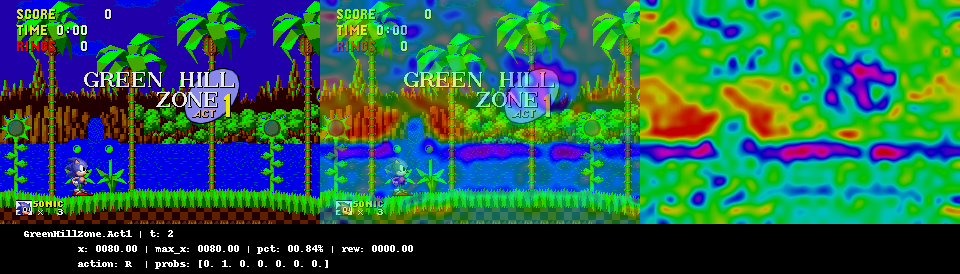

In [7]:
actor_critic = model[0]

recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size).to(device)
masks = torch.zeros(1, 1).to(device)

obs = env.reset()
i = 0
while True:
    if i >= 3:
        break
    with torch.no_grad():
        value, action, _, recurrent_hidden_states = actor_critic.act(
            obs, recurrent_hidden_states, masks, deterministic=True)
    
    if i == 0:
        x = 0
        max_x = 0
        pct = 0
        rew = 0
    else:
        x = info[0]['x']
        max_x = info[0]['max_x']
        pct = info[0]['max_x']/info[0]['lvl_max_x']*100
        rew = info[0]['sum_r']
    print(ACTIONS[action.item()])
    t = i
    a = action.item()
    tgt_layer = 5
    f = gen_eval_vid_frame(actor_critic, env_state, x, max_x, pct, rew, t, a, obs, tgt_layer)
    print(f.shape)
    display(Image.fromarray(f, 'RGB'))
    

    # Obser reward and next obs
    obs, reward, done, info = env.step(action)
    masks.fill_(0.0 if done else 1.0)
    
    if done:
        print(f"max_x {info[0]['max_x']}, stage len {info[0]['screen_x_end']}")
        break
    i += 1